In [ ]:
# !pip install lightgbm
# !pip install catppuccin-matplotlib
# !git clone --recursive https://github.com/Microsoft/LightGBM

In [1]:
# Import necessary libraries
import pandas as pd
from numpy import *
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
import warnings
import pickle

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.preprocessing import StandardScaler

import mplcatppuccin
import matplotlib as mpl
mpl.style.use(["ggplot", "mocha"])
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 15

In [ ]:
# %%bash
# cd LightGBM
# rm -r build
# mkdir build
# cd build
# cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
# make -j$(nproc)

In [ ]:
# !cd LightGBM/python-package/;python setup.py install --precompile
# !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# !rm -r LightGBM

In [2]:
# The directory for top level folder
dir_ = "/home/sugam/Work/20-29 Deep Learning/22 Projects/Optimization of Energy Using AIML"

processed_data_dir = dir_+'/data/Processed/'
model_dir = dir_+'/models/'
report_dir = dir_ + "/reports/figures/"

In [4]:
target_columns = "load"

In [5]:
# Load your dataset
train_data =  pd.read_csv(processed_data_dir + "train.csv")
validation_data =  pd.read_csv(processed_data_dir + "validation.csv")
test_data =  pd.read_csv(processed_data_dir + "test.csv")

In [6]:
X_train, y_train = train_data.drop(target_columns, axis=1), train_data[target_columns]
X_valid, y_valid = validation_data.drop(target_columns, axis=1), validation_data[target_columns]
X_test, y_test = test_data.drop(target_columns, axis=1), test_data[target_columns]

In [7]:
print(f"Size of training data {X_train.shape}")
print(f"Size of validation data {X_valid.shape}")
print(f"Size of testing data {X_test.shape}")

Size of training data (82437, 50)
Size of validation data (10305, 50)
Size of testing data (10305, 50)


In [9]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_valid_scaled = ss.transform(X_valid)
X_test_scaled = ss.transform(X_test)

In [10]:
# Create dataset for gbm
dtrain = lgb.Dataset(X_train_scaled, label=y_train)
dvalid = lgb.Dataset(X_valid_scaled, label=y_valid)

params = {
    "device_type" : "cpu", # put gpu if you have one
    "max_depth" : 20,
    "n_jobs" : -1
}
num_round = 124

random.seed(1234)
lgb_model = lgb.train(params, dtrain,num_round, valid_sets = [dvalid])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10339
[LightGBM] [Info] Number of data points in the train set: 82437, number of used features: 50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 57.878375


In [11]:
model_name = model_dir+'lgb_base.bin'
pickle.dump(lgb_model, open(model_name, 'wb'))

In [12]:
with open(model_name, 'rb') as file:  
    lgb_base = pickle.load(file)

In [13]:
lgb_valid_predictions = lgb_base.predict(X_valid_scaled)
lgb_rmse_valid = mean_squared_error(y_valid, lgb_valid_predictions, squared=False)

lgb_train_predictions = lgb_base.predict(X_train_scaled)
lgb_rmse_train = mean_squared_error(y_train, lgb_train_predictions, squared=False)

print(f'LGBM RMSE Train: {lgb_rmse_train}')
print(f'LGBM RMSE Validation: {lgb_rmse_valid}')


LGBM RMSE Train: 1.6493679083414492
LGBM RMSE Validation: 2.690219248014617


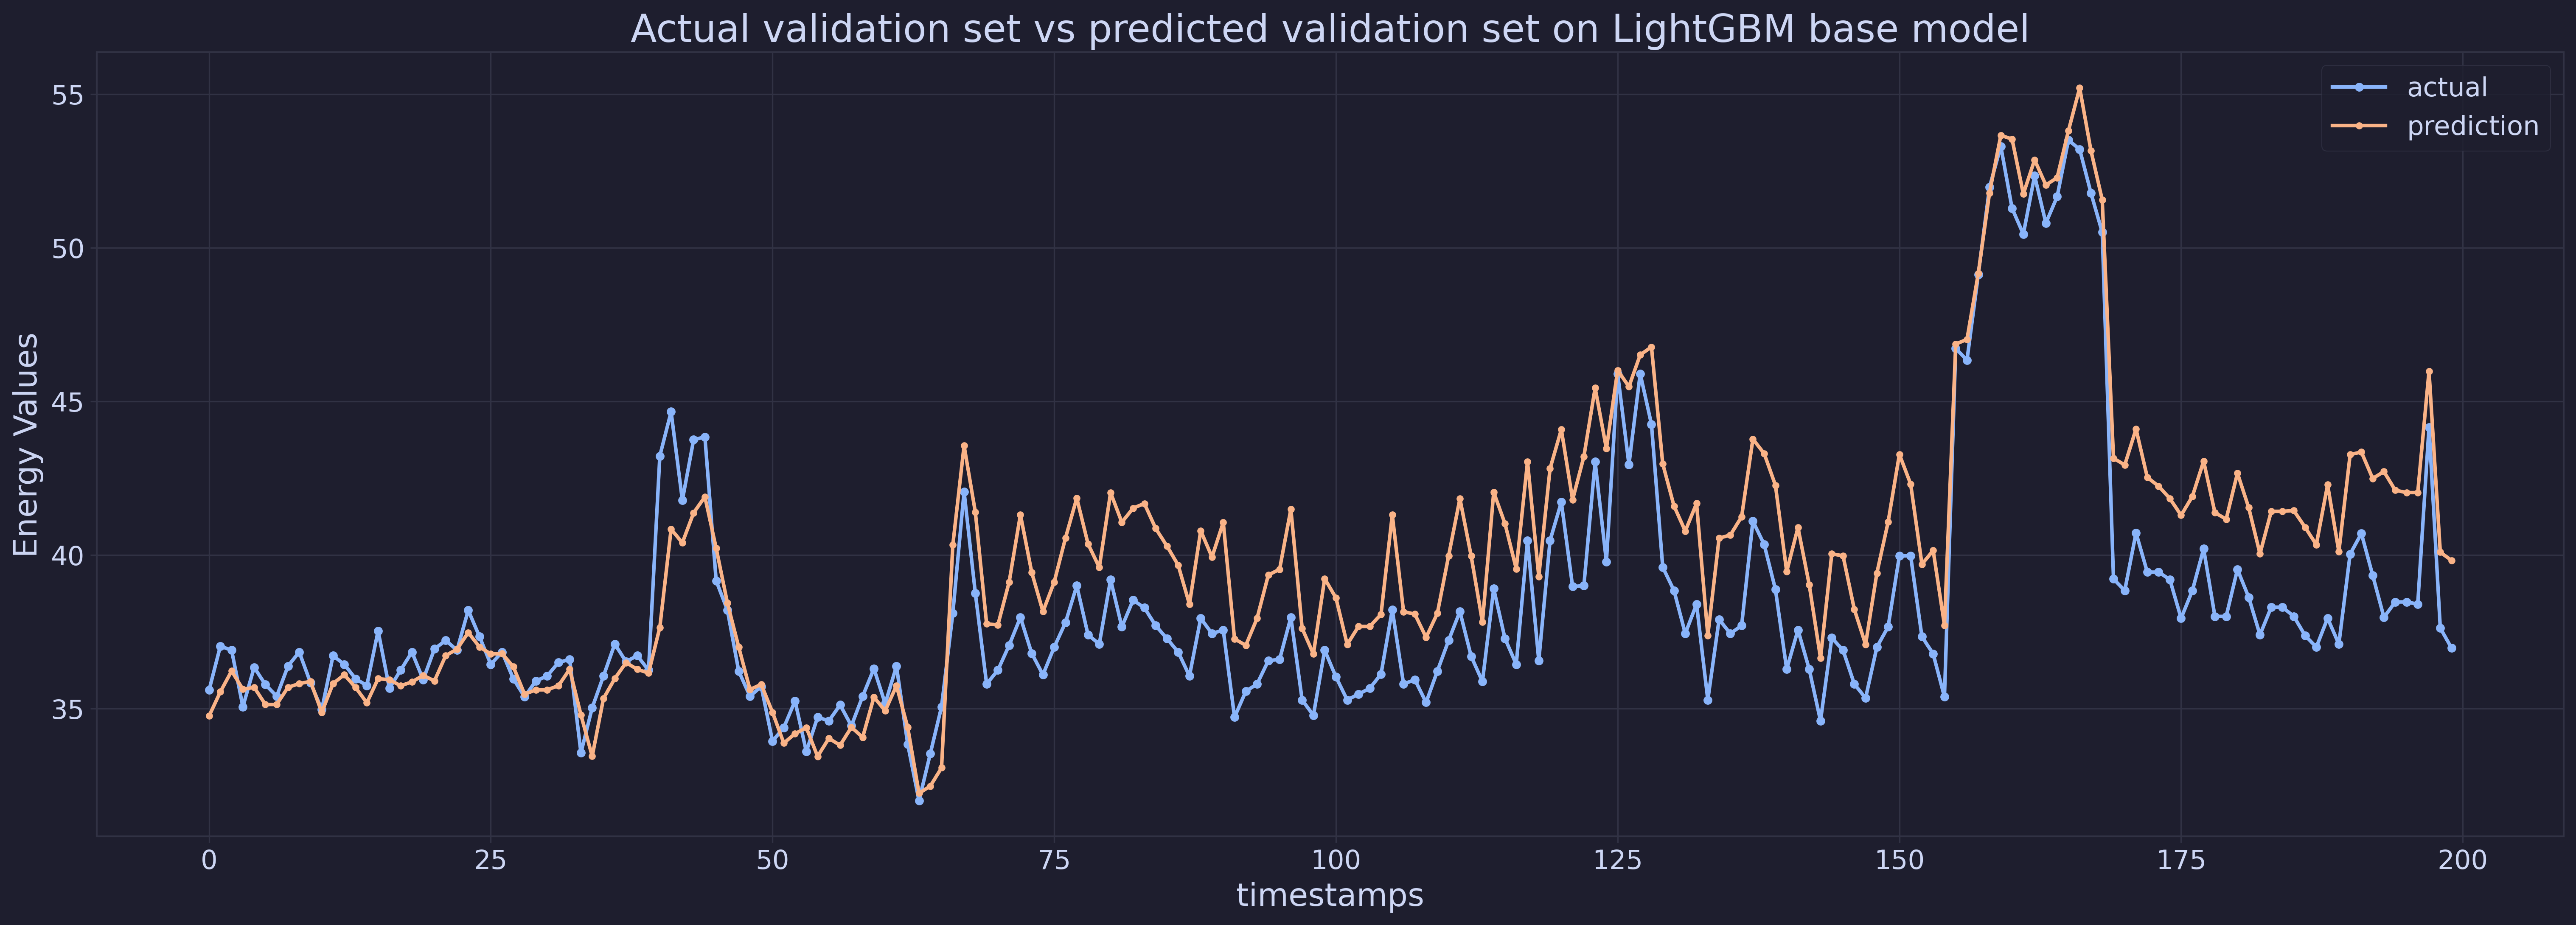

In [14]:
fig = plt.figure()
plt.plot(y_valid.values[:200], linewidth=2, marker = 'o', ms=4)
plt.plot(lgb_valid_predictions[:200], linewidth=2, marker = 'o', ms=3)
plt.legend(["actual","predicted"])
plt.title("Test Set Prediction")
plt.title("Actual validation set vs predicted validation set on LightGBM base model")
plt.legend(["actual","prediction"])
plt.xlabel("timestamps")
plt.ylabel("Energy Values");

In [15]:
lgb_test_predictions = lgb_model.predict(X_test_scaled)
lgb_rmse_test = mean_squared_error(y_test, lgb_test_predictions, squared=False)
print(f'LGBM RMSE Test: {lgb_rmse_test}')

LGBM RMSE Test: 1.9092727376819163


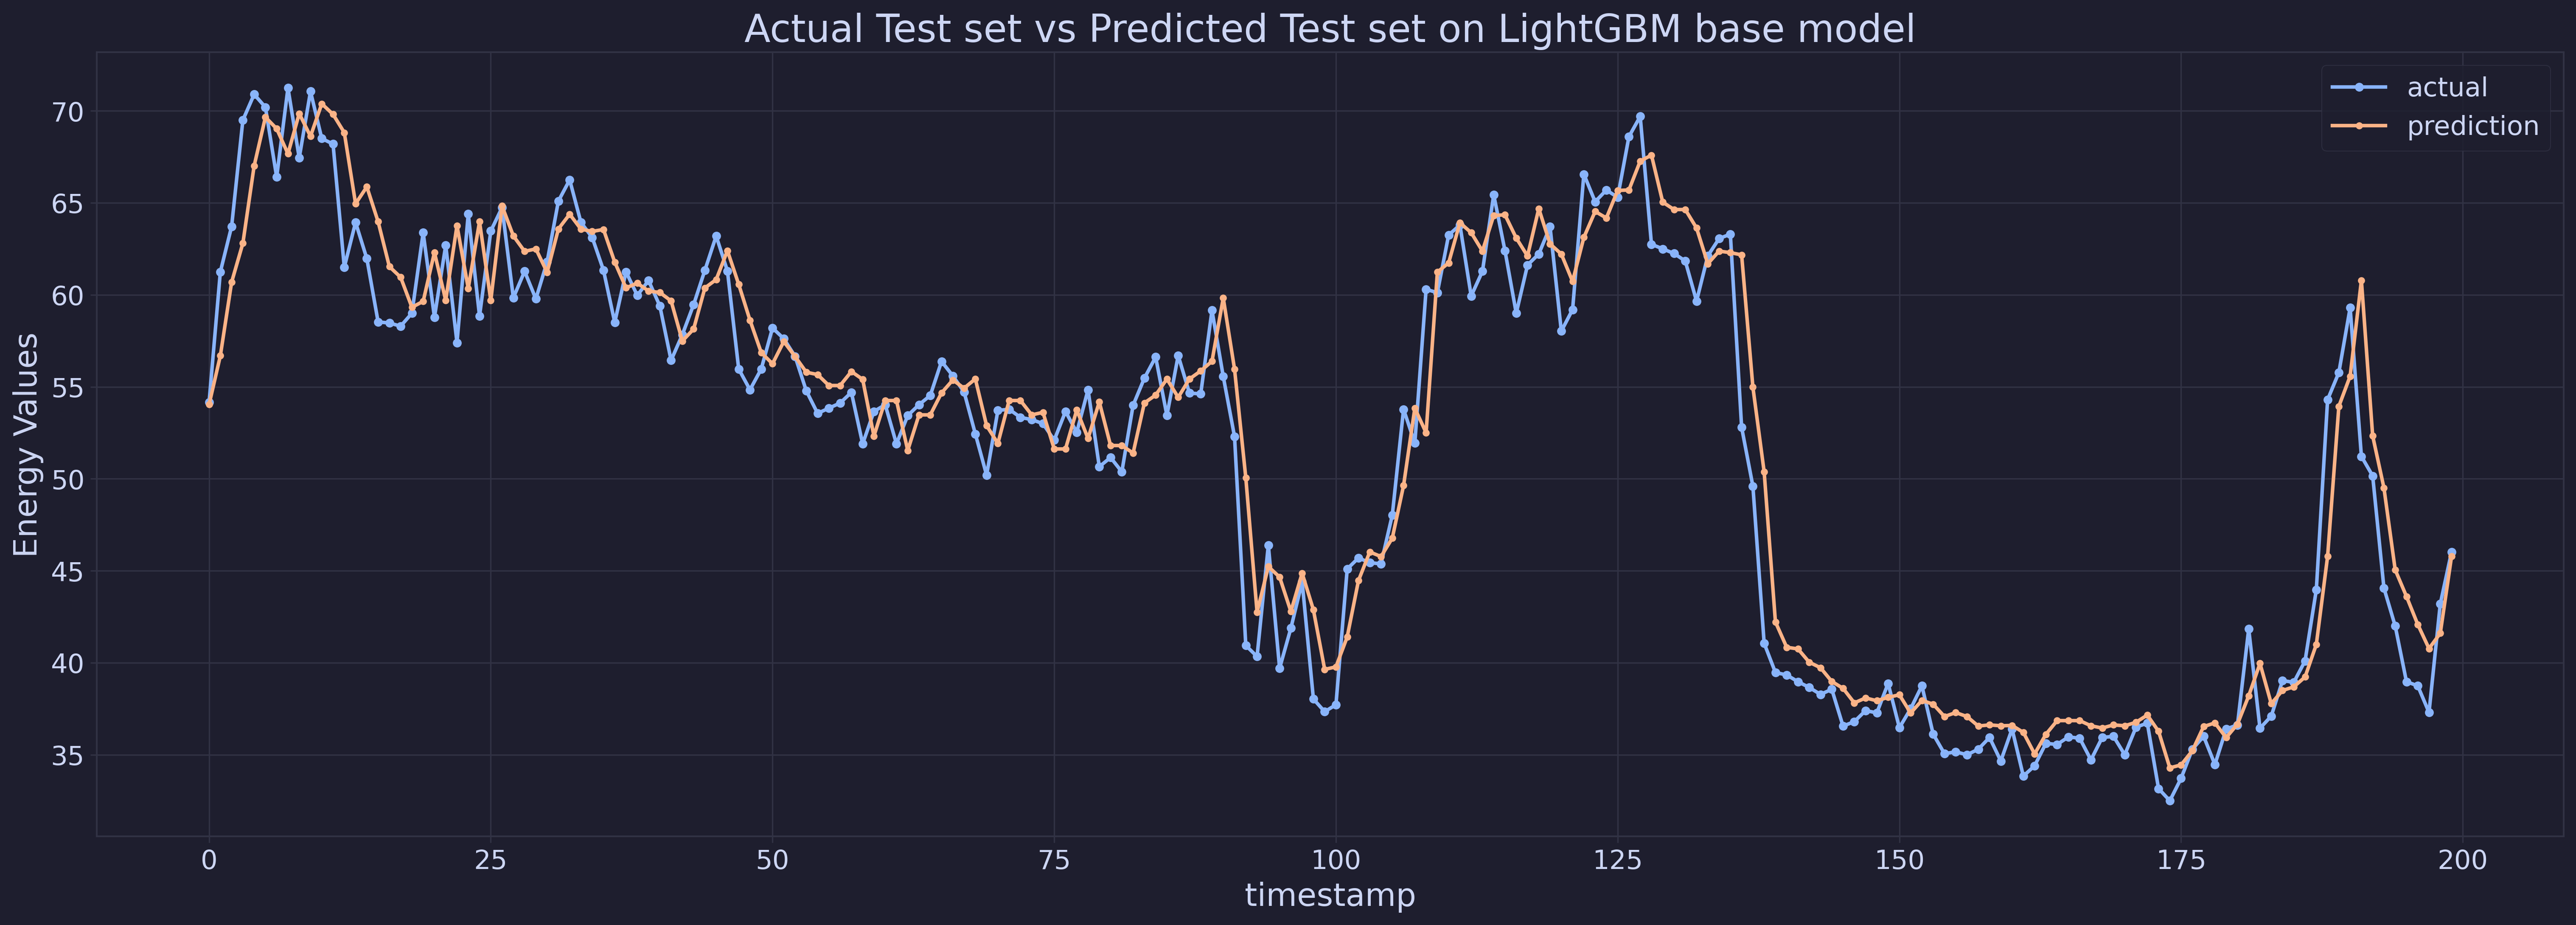

In [16]:
fig = plt.figure()
plt.plot(y_test.values[:200], linewidth=2, marker = 'o', ms=4)
plt.plot(lgb_test_predictions[:200], linewidth=2, marker = 'o', ms=3)
plt.legend(["actual","predicted"])
plt.title("Test Set Prediction")
plt.title("Actual Test set vs Predicted Test set on LightGBM base model")
plt.legend(["actual","prediction"])
plt.xlabel("timestamp")
plt.ylabel("Energy Values");

In [ ]:
# # This is an objective function for optuna do not run this code
# def objective(trial):

    
#     data_sample_strategy = trial.suggest_categorical("data_sample_strategy",["bagging","goss"])
#     n_estimators = trial.suggest_int("n_estimators",50,500)
#     learning_rate = trial.suggest_float("learning_rate",1e-3,1e-1,log=True)
#     num_leaves = trial.suggest_int("num_leaves",50,256)
#     tree_learner = trial.suggest_categorical("tree_learner",["serial","feature","data","voting"])
#     max_depth = trial.suggest_int("max_depth",50,100)
#     min_data_in_leaf = trial.suggest_int("min_data_in_leaf",50,100)
#     path_smooth = trial.suggest_int("path_smooth",5,10) # Larger values give stronger regularization , helps prevent overfitting on leaves with few samples
#     l1_regularization = trial.suggest_loguniform("l1_regularization",1e-8,10)
    
#     params = {"data_sample_strategy":data_sample_strategy,
#               "n_estimators": n_estimators,
#              "learning_rate":learning_rate,
#              "num_leaves":num_leaves,
#              "tree_learner":tree_learner,
#              "max_depth":max_depth,
#              "min_data_in_leaf":min_data_in_leaf,
#              "path_smooth":path_smooth,
#              "boosting" : "dart",
#              "bagging_freq" : 5, # After every 5th iteration it will perform bagging
#              "bagging_fraction" : 0.3, # After every 5 iteration it will select 30% of the data
#              "bagging_seed" : 0,
#               "feature_fraction" : 0.4 ,
#               "early_stopping_round" : 5, # Stop the training if the validation accuracy doesnot improve in 5 rounds
#               "l1_regularization" : l1_regularization,
#               "n_jobs" : -1,
#               "verbose" : 3,
#               "device_type" : "gpu",
#               "random_state" : 0,
#              }
#     num_rounds = 10
#     gbm = lgb.train(params,
#                     dtrain,
#                     num_rounds,
#                     valid_sets = [dvalid])
#     preds = gbm.predict(X_valid_scaled)
#     rmse_score = mean_squared_error(y_valid,
#                                     preds,
#                                     squared=False)
#     return rmse_score

# with tf.device('/gpu:0'): 
#     study = optuna.create_study(direction="minimize",
#                                 study_name="light_gbm_study")
#     study.optimize(objective, n_trials=20)
    
# trial = study.best_trial
# print(f"RMSE: {trial.value}")
# print(f"Params: {trial.params}")

In [17]:
Params= {"boosting" : "dart",
         'data_sample_strategy': 'goss',
         #"bagging_freq" : 5, # After every 5th iteration it will perform bagging
         "bagging_fraction" : 0.3, # After every 5 iteration it will select 30% of the data
         "bagging_seed" : 0,
         "feature_fraction" : 0.4 ,
         "early_stopping_round" : 5, # Stop the training if the validation accuracy doesnot improve in 5 rounds
         'n_estimators': 493,
         'learning_rate': 0.09045620673160655,
         'num_leaves': 190,
         'tree_learner': 'data',
         'max_depth': 52,
         'min_data_in_leaf': 65,
         'path_smooth': 6,
         'l1_regularization': 4.5522678350030745e-05,
         "device": "cpu", # put gpu if you have one
         "n_jobs" : -1,
         "verbose" : 1,
         "random_state" : 0,         
        }

In [19]:
num_rounds = 10
random.seed(1234)
gbm = lgb.train(Params,
                    dtrain,
                    num_rounds,
                    valid_sets = [dvalid])
    

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10339
[LightGBM] [Info] Number of data points in the train set: 82437, number of used features: 50
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 57.878375


In [20]:
## Saving the model
model_name = model_dir+'lgb_final.bin'
pickle.dump(gbm, open(model_name, 'wb'))

In [21]:
## Loading the model
with open(model_name, 'rb') as file:  
    lgb_final = pickle.load(file)

In [22]:
preds_train = lgb_final.predict(X_train_scaled)
rmse_score_train = mean_squared_error(y_train,
                                    preds_train,
                                    squared=False)

preds_valid = lgb_final.predict(X_valid_scaled)
rmse_score_valid = mean_squared_error(y_valid,
                                    preds_valid,
                                    squared=False)
preds_test = lgb_final.predict(X_test_scaled)
rmse_score_test = mean_squared_error(y_test,
                                    preds_test,
                                    squared=False)

print(f"The train RMSE score {rmse_score_train}")
print(f"The validation RMSE score {rmse_score_valid}")  
print(f"The test RMSE score {rmse_score_test}")

The train RMSE score 2.625680752481525
The validation RMSE score 2.9911658813129103
The test RMSE score 2.32690756657805


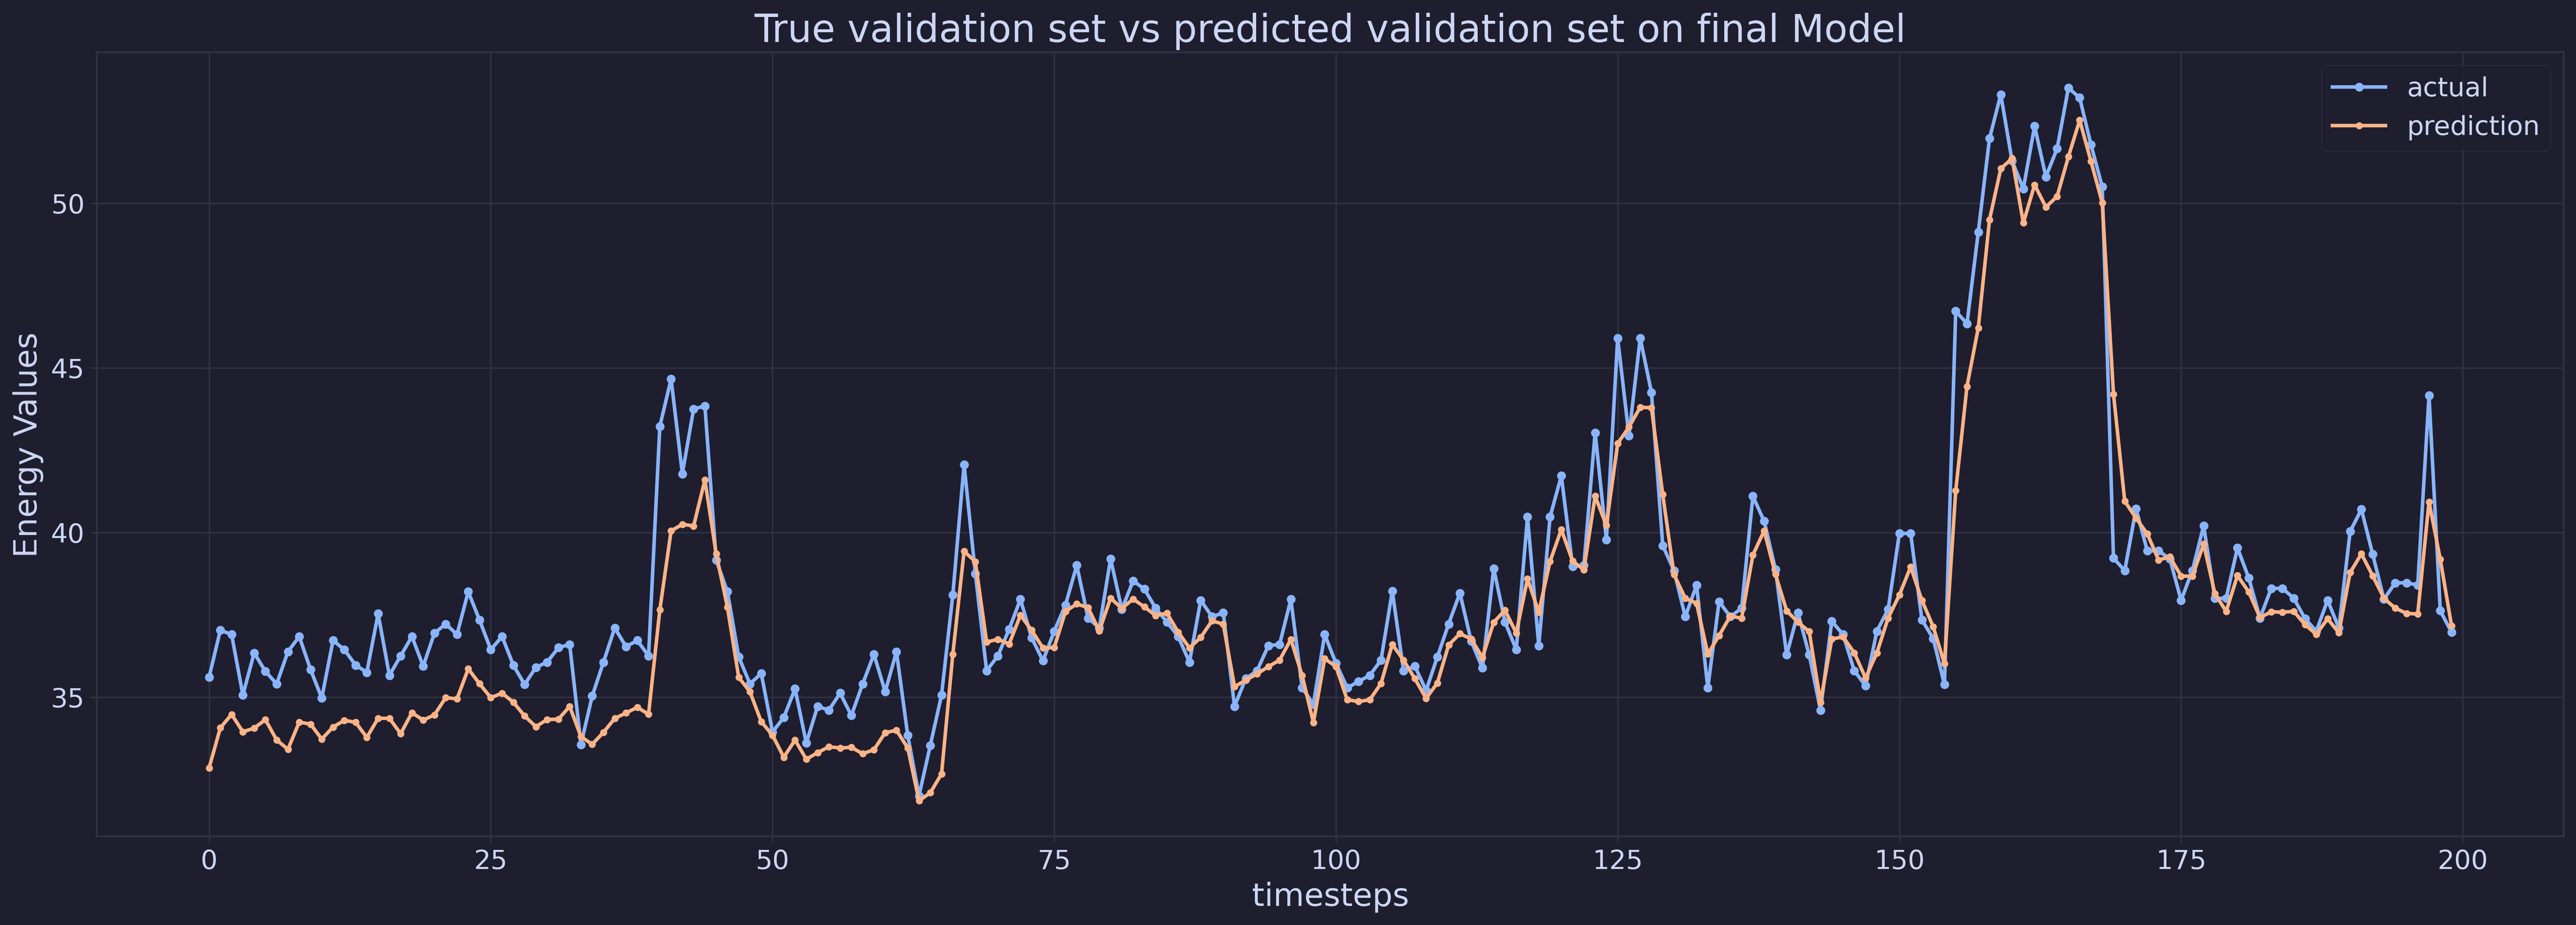

In [24]:
fig = plt.figure()
plt.plot(y_valid.values[:200], linewidth=2, marker = 'o', ms=4)
plt.plot(preds_valid[:200], linewidth=2, marker = 'o', ms=3)
plt.legend(["actual","predicted"])
plt.title("Validation Set Prediction")
plt.title("True validation set vs predicted validation set on final Model")
plt.legend(["actual","prediction"])
plt.xlabel("timesteps")
plt.ylabel("Energy Values");


plt.savefig(report_dir + "lightgbm_validation_set_line_graph.jpg", 
            dpi=500,
            format=None,
            transparent=False,
            bbox_inches=None, 
            pad_inches=0.1)

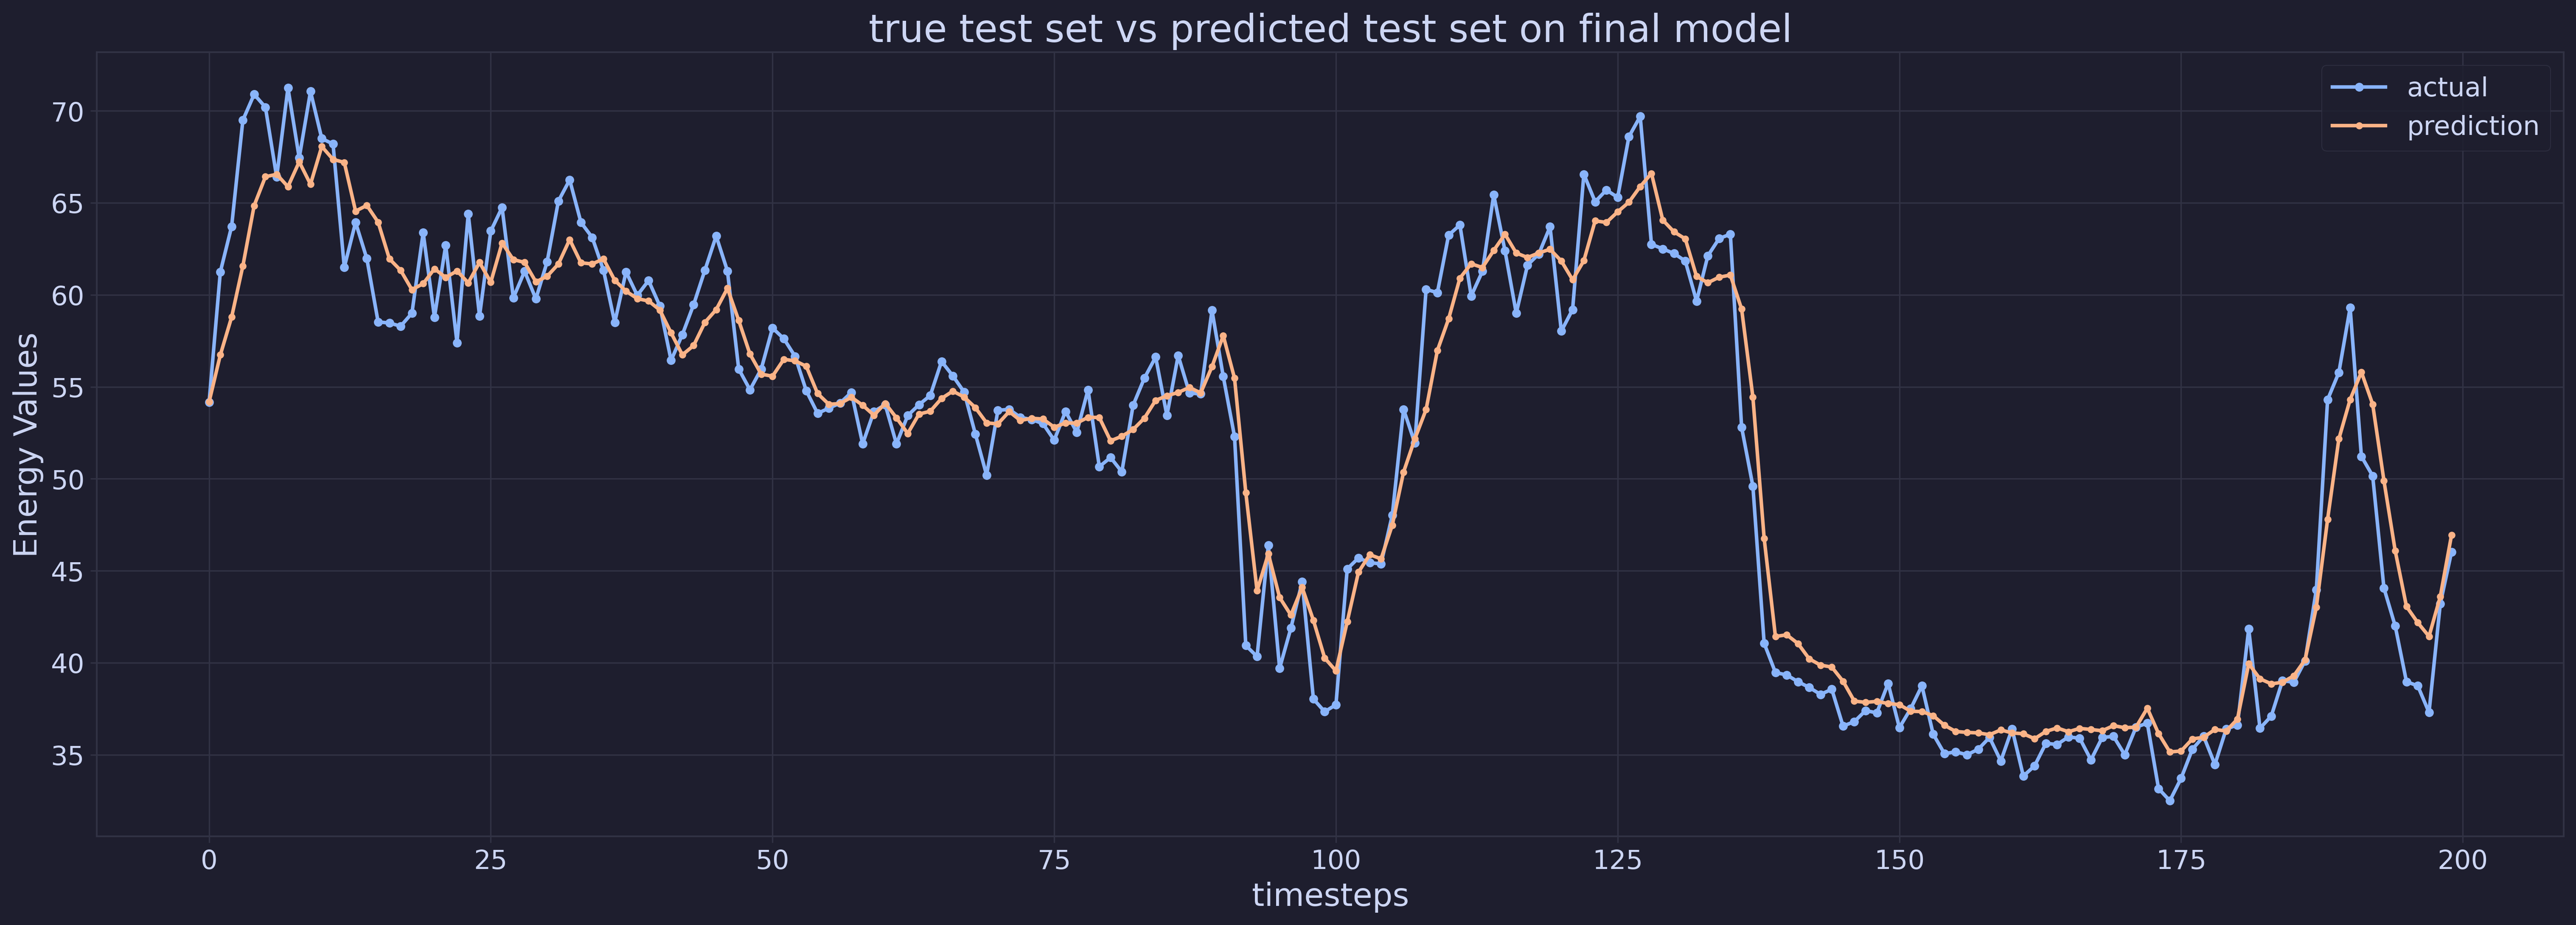

In [25]:
fig = plt.figure(figsize=(25,8))
plt.plot(y_test.values[:200], linewidth=2, marker = 'o', ms=4)
plt.plot(preds_test[:200], linewidth=2, marker = 'o', ms=3)
plt.legend(["actual","predicted"])
plt.title("Validation Set Prediction")
plt.title("true test set vs predicted test set on final model")
plt.legend(["actual","prediction"])
plt.xlabel("timesteps")
plt.ylabel("Energy Values")

plt.savefig(report_dir + "lightgbm_test_set_line_graph.jpg", 
            dpi=500,
            format=None,
            transparent=False,
            bbox_inches=None, 
            pad_inches=0.1);